In [1]:
import os, sys, time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.options.mode.chained_assignment = None
import h5py

%matplotlib inline

from IPython.display import display, HTML

if (sys.version_info < (3, 0)):
    HTML('''<script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
# Create timestamp to show when this summary was run
print('Summary run: ' + time.strftime("%a, %d %b %Y %H:%M"))

Summary run: Tue, 02 Jul 2024 13:20


In [3]:
# Daysim data
trip = pd.read_csv(r'../../../outputs/daysim/_trip.tsv', sep='\t')
person = pd.read_csv(r'../../../outputs/daysim/_person.tsv', sep='\t')
hh = pd.read_csv(r'../../../outputs/daysim/_household.tsv', sep='\t')

In [4]:
pd.options.display.float_format = '{:0,.2f}'.format

In [5]:
# Weekdays in year
annual_factor = 300
minutes_to_hour =60

# Soundcast Metrics
----

### Average Daily Miles Driven per Person

In [6]:
if 'sov_ff_time' in trip.columns:
    drive_modes = [3, 4, 5]
    drive_trips = trip[['mode', 'dorp', 'travtime', 'sov_ff_time', 'travdist']].loc[trip['mode'].isin(drive_modes)]
    only_driver = drive_trips.loc[drive_trips['dorp']==1]
    avg_vmt = only_driver['travdist'].sum()/ person['psexpfac'].sum()
    print('Average Daily VMT per person, not including externals or trucks: '+ str(avg_vmt))

Average Daily VMT per person, not including externals or trucks: 14.71649014429725


### Hours of Congestion per Person per Year
For average Puget Sound resident:

In [7]:
if 'sov_ff_time' in trip.columns:
    drive_trips['delay'] = drive_trips['travtime']-(drive_trips['sov_ff_time']/100.0)
    drive_mode_delay =annual_factor*(drive_trips['delay'].sum()/person['psexpfac'].sum())/minutes_to_hour
    print('Annual hours of delay for residents, not including externals or trucks is ' + str(drive_mode_delay))

Annual hours of delay for residents, not including externals or trucks is 21.028989459405057


### Annual Hours of Delay by Average Truck
Average annual delay (hours) per truck trip in and through the region:

In [8]:
# Total truck trips

In [9]:
# Load truck trips
df = pd.read_csv(r'../../../outputs/trucks/trucks_summary.csv',index_col=0)

# Truck delay
net_sum = pd.read_excel(r'../../../outputs/network/network_summary.xlsx', 'Delay by UC')

# Annual delay hours
daily_delay = net_sum[['@mveh','@hveh']].sum().sum()


# total truck trips
trips = df['prod'].sum()

# average annual delay hours per truck
x = (daily_delay*annual_factor)/trips
print('{:0,.1f}'.format(x))

26.9


*Medium trucks only:*

In [10]:
x = (net_sum['@mveh'].sum()*annual_factor)/df.loc['mt','prod']
print('{:0,.1f}'.format(x))

19.5


*Heavy trucks only:*

In [11]:
x = (net_sum['@hveh'].sum()*annual_factor)/df.loc['ht','prod']
print ('{:0,.1f}'.format(x))

50.3


### % Population Walking or Biking for Transportation

In [12]:
trip_person = pd.merge(trip,person,on=['hhno','pno'], how='left')
bike_walk_trips = trip_person[trip_person['mode'].isin([1,2])]

df = bike_walk_trips.groupby(['hhno','pno']).count()
df = df.reset_index()
df = df[['hhno','pno']]
df['bike_walk'] = True

df = pd.merge(person,df,on=['hhno','pno'], how='left')
df['bike_walk'] = df['bike_walk'].fillna(False)

pd.options.display.float_format = '{:,.1%}'.format
df = pd.DataFrame(df.groupby('bike_walk').sum()['psexpfac']/df['psexpfac'].sum())
print('{:,.1%}'.format(df.loc[True]['psexpfac']))

23.6%


## Household and Jobs within 1/4 mile transit

In [13]:
# Network data
df = pd.read_csv(r'../../../outputs/transit/transit_access.csv',index_col=0)

**Households**

In [14]:
x = df.loc['hh_p','quarter_mile_transit']
print('{:,.0f}'.format(x) + (" households within 1/4 mile of transit"))
x = df.loc['hh_p','quarter_mile_transit']/df.loc['hh_p','total']
print('{:,.1%}'.format(x) + (" of total households"))

828,936 households within 1/4 mile of transit
47.7% of total households


**Jobs**

In [15]:
x = df.loc['emptot_p','quarter_mile_transit']
print('{:,.0f}'.format(x) + (" jobs within 1/4 mile of transit"))
x = df.loc['hh_p','quarter_mile_transit']/df.loc['emptot_p','total']
print('{:,.1%}'.format(x) + (" of total jobs"))

1,526,107 jobs within 1/4 mile of transit
38.0% of total jobs


# Commute Times

In [16]:
pd.options.display.float_format = '{:0,.2f}'.format

In [17]:
workers = person.loc[person['pwautime']>0]
binned_times = pd.cut(workers['pwautime'], [0, 15, 30, 45, 60, 90, 200])
count_times = pd.value_counts(binned_times).sort_index()
print(count_times)

(0, 15]      632938
(15, 30]     744686
(30, 45]     423313
(45, 60]     231386
(60, 90]     135707
(90, 200]     42071
Name: pwautime, dtype: int64


<AxesSubplot:>

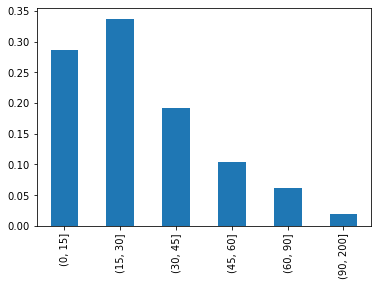

In [18]:
(count_times*1.0/len(workers)).plot.bar()